<a href="https://colab.research.google.com/github/wenchaohu/mafs5140/blob/master/gan_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Model Experiments
This Colab notebook contains implementations of both AC GAN and DC GAN, based on PyTorch. 

The training images are downsampled into 64x64 for better performance.

The experiements demonstrates that more training iterations tend to lead to better results for both models on the portrait dataset.

Common code sections
--------------
Load common modules

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data as t_data
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.utils as vutils
import random

Generate random numbers for reproducing the same result

In [3]:
seed = 123
random.seed(seed)
torch.manual_seed(seed)

Define global parameters

In [0]:
# RGB for portrait
nb_channels = 3
# Number of latent variable z
nb_latents = 100
# first beta for Adam optimizer
beta1 = 0.5
# second beta for Adam optimizer
beta2 = 0.999
# learning rate for Adam optimizer
lr = 0.0002
# Use GPU on Colab
device = torch.device("cuda:0")
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# image dimensions
image_size = 64
# Batch size during training
batch_size = 128

Load training images from Google drive

In [0]:
img_base_dir = r'drive/My Drive/mafs6010s/data'

all_real_data = datasets.ImageFolder(
    root=img_base_dir,
    transform=transforms.Compose([
      transforms.Resize(image_size),
      transforms.CenterCrop(image_size),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(all_real_data, batch_size=batch_size,
                                          shuffle=True, num_workers=4)



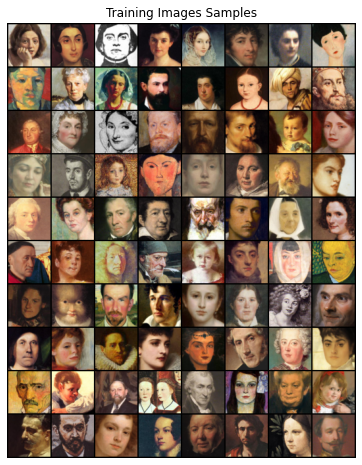

In [8]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 8))
plt.axis("off")
plt.title("Training Images Samples")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:8*10], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

Weights initialization function

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# AC GAN

Define generator

In [0]:
# number of classes used in AC GAN
nb_class = 10

In [0]:
class ACGenerator(nn.Module):
    def __init__(self):
        super(ACGenerator, self).__init__()

        self.label_embed = nn.Embedding(nb_class, nb_latents)

        self.init_size = image_size // 4 
        self.layer1 = nn.Sequential(nn.Linear(nb_latents, 128 * self.init_size ** 2))

        self.net = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, nb_channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_embed(labels), noise)
        out = self.layer1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.net(out)
        return img

Define discriminator

In [0]:
class ACDiscriminator(nn.Module):
    def __init__(self):
        super(ACDiscriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), 
                     nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(nb_channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        dim = image_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(
            nn.Linear(128 * dim ** 2, 1), nn.Sigmoid()
            )
        self.aux_layer = nn.Sequential(
            nn.Linear(128 * dim ** 2, nb_class), nn.Softmax()
            )

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        adv = self.adv_layer(out)
        label = self.aux_layer(out)
        return adv, label

Define loss functions

In [32]:
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

adversarial_loss.cuda()
auxiliary_loss.cuda()

CrossEntropyLoss()

Construct generator and discriminator

In [0]:
ac_g = ACGenerator().to(device)
ac_d = ACDiscriminator().to(device)

Initialize weights

In [34]:
ac_g.apply(weights_init)
ac_d.apply(weights_init)

ACDiscriminator(
  (conv_blocks): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (

Construct optimizer for generator and discriminator

In [0]:
optim_g = torch.optim.Adam(ac_g.parameters(), lr=lr, betas=(beta1, beta2))
optim_d = torch.optim.Adam(ac_d.parameters(), lr=lr, betas=(beta1, beta2))

Container to cellect results

In [0]:
img_list = []
g_losses = []
d_losses = []
iters = 0

Start training

In [0]:
num_epochs = 10
FloatTensor = torch.cuda.FloatTensor
LongTensor = torch.cuda.LongTensor
nb_row = nb_class
res_gen_noise = Variable(FloatTensor(np.random.normal(0, 1, (nb_row ** 2, nb_latents))))
res_gen_label = np.array([n for _ in range(nb_row) for n in range(nb_row)])
res_gen_label = Variable(LongTensor(res_gen_label))

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        batch_size = imgs.shape[0]

        real = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        optim_g.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, nb_latents))))
        gen_labels = Variable(LongTensor(np.random.randint(0, nb_class, batch_size)))

        # Generate a batch of images
        gen_imgs = ac_g(z, gen_labels)

        # measure generation loss on image and class labeling
        judgement, pred_label = ac_d(gen_imgs)
        g_loss = 0.5 * (adversarial_loss(judgement, real) + auxiliary_loss(pred_label, gen_labels))

        g_loss.backward()
        
        optim_g.step()

        ##  Train Discriminator
        optim_d.zero_grad()

        # Loss for real images
        real_pred, real_aux = ac_d(real_imgs)
        d_real_loss = (adversarial_loss(real_pred, real) + auxiliary_loss(real_aux, labels)) / 2

        # Loss for fake images
        fake_pred, fake_aux = ac_d(gen_imgs.detach())
        d_fake_loss = (adversarial_loss(fake_pred, fake) + auxiliary_loss(fake_aux, gen_labels)) / 2

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        # Calculate discriminator accuracy
        pred = np.concatenate([real_aux.data.cpu().numpy(), fake_aux.data.cpu().numpy()], axis=0)
        gt = np.concatenate([labels.data.cpu().numpy(), gen_labels.data.cpu().numpy()], axis=0)
        d_acc = np.mean(np.argmax(pred, axis=1) == gt)

        d_loss.backward()
        optim_d.step()

        # Output training stats
        if i % 100 == 0:
            print(
                "[%d/%d] [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f"
                % (epoch, num_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        # Save Losses for plotting later
        g_losses.append(d_loss.item())
        d_losses.append(g_loss.item())

        # save the results periodically
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            fake = ac_g(res_gen_noise, res_gen_label)
            img_list.append(vutils.make_grid(fake.data, padding=2, normalize=True))

        iters += 1

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[0/10] [0/88]	Loss_D: 1.2911	Loss_G: 1.5116
[1/10] [0/88]	Loss_D: 1.2641	Loss_G: 1.4575


Plot D & G’s losses versus training iterations

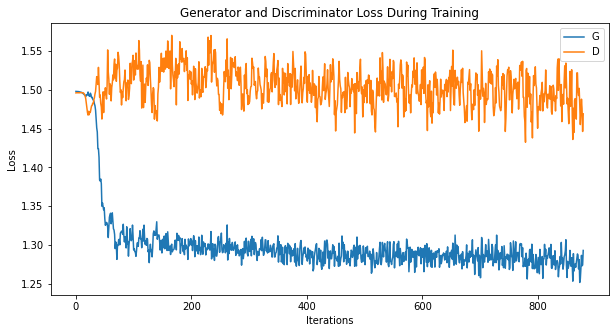

In [38]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Show some generated images

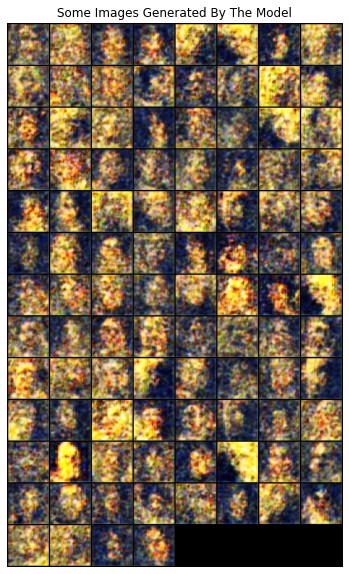

In [39]:
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Some Images Generated By The Model")
plt.imshow(np.transpose(img_list[-1].cpu().detach(), (1, 2, 0)))
plt.show()

# DC GAN

The example of DC GAN in PyTorch document was amended and customized for comparison.

Define DC GAN generator 



In [0]:
class DCGenerator(nn.Module):
    def __init__(self):
        super(DCGenerator, self).__init__()
        self.net = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nb_latents, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nb_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.net(input)

Define DC GAN discriminator

In [0]:

class DCDiscriminator(nn.Module):
    def __init__(self):
        super(DCDiscriminator, self).__init__()
        self.net = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nb_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)

Construct generator and discriminator

In [0]:
dc_g = DCGenerator().to(device)
dc_d = DCDiscriminator().to(device)

Initialize weights

In [0]:
dc_g.apply(weights_init)
dc_d.apply(weights_init)

Define loss functions

In [0]:
loss_func = nn.BCELoss()

Initialize optimizer

In [0]:
optim_g = torch.optim.Adam(dc_g.parameters(), lr=lr, betas=(beta1, beta2))
optim_d = torch.optim.Adam(dc_d.parameters(), lr=lr, betas=(beta1, beta2))

Reset result container

In [0]:
img_list = []
g_losses = []
d_losses = []
iters = 0

Start Trainig DC GAN

In [0]:
num_epochs = 10
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        dc_d.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = dc_d(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = loss_func(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = dc_g(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = dc_d(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_func(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optim_d.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        dc_g.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = dc_d(fake).view(-1)
        # Calculate G's loss based on this output
        errG = loss_func(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optim_g.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        g_losses.append(errG.item())
        d_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = dc_g(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1